In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
embedding_dim = 200
max_length = 120
filters = 64
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
emoji_list = emoji.UNICODE_EMOJI.keys()


In [4]:
data = pd.read_csv("Twitter_Data.csv")
labels = data['Annotation']
texts = data['Tweets']
print(len(texts))
print(len(labels))

16907
16907


In [5]:
FLAGS = re.MULTILINE | re.DOTALL

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
    no_emoji = ''
    for char in text:
        if char not in emoji_list:
            no_emoji = no_emoji + char
        else:
            no_emoji = no_emoji + '<' + emoji.demojize(char) + '> '
    text = no_emoji
    
    text = re_sub(r"@\w+","<user>")
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct
    text = text.replace("  "," ")
    text = text.replace("\n"," ")
    return text.lower()


In [6]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

E:\Programs\Anaconda\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
print(texts[2213])

<user> <user> you are absolute scum


In [8]:
print(set(labels))

{'sexism', 'racism', 'none'}


In [9]:
divide = int(len(data)*training_portion)
train_tweets, validation_tweets, train_labels, validation_labels = texts[:divide], texts[divide:], labels[:divide], labels[divide:]
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))

13525
13525
3382
3382


In [10]:
vocab_size=0
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index
vocab_size=len(word_index)

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(word_index))
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

15060
13
120
22
120


In [11]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [12]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [13]:
print(train_padded.shape)
print(train_lables_padded.shape)

(13525, 120)
(13525, 1)


In [14]:
embeddings_index = {};
with open('glove.6B.200d.txt', errors='ignore') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:])#, dtype='float32')
        embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [15]:
def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 20s - loss: 0.6570 - acc: 0.7316 - val_loss: 0.5049 - val_acc: 0.7995
Epoch 2/10
13525/13525 - 12s - loss: 0.4669 - acc: 0.8055 - val_loss: 0.4570 - val_acc: 0.8125
Epoch 3/10
13525/13525 - 12s - loss: 0.4278 - acc: 0.8253 - val_loss: 0.4449 - val_acc: 0.8164
Epoch 4/10
13525/13525 - 12s - loss: 0.4028 - acc: 0.8343 - val_loss: 0.4326 - val_acc: 0.8241
Epoch 5/10
13525/13525 - 12s - loss: 0.3762 - acc: 0.8450 - val_loss: 0.4246 - val_acc: 0.8288
Epoch 6/10
13525/13525 - 13s - loss: 0.3540 - acc: 0.8535 - val_loss: 0.4293 - val_acc: 0.8214
Epoch 7/10
13525/13525 - 12s - loss: 0.3339 - acc: 0.8652 - val_loss: 0.4301 - val_acc: 0.8279
Epoch 8/10
13525/13525 - 13s - loss: 0.3153 - acc: 0.8699 - val_loss: 0.4419 - val_acc: 0.8267
Epoch 9/10
13525/13525 - 13s - loss: 0.2979 - acc: 0.8807 - val_loss: 0.4401 - val_acc: 0.8241
Epoch 10/10
13525/13525 - 14s - loss: 0.2812 - acc: 0.8873 - val_loss: 0.4808 - val_acc: 0.8261


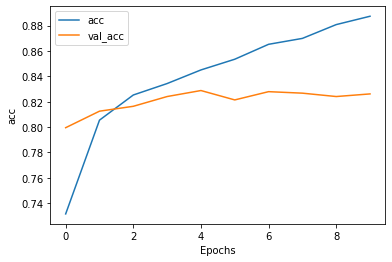

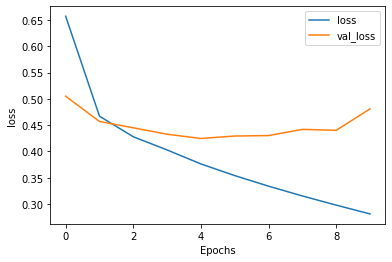

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = max_length, weights=[embeddings_matrix], trainable=False),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.005), metrics=['acc'])
# model.summary()
#adam(lr=.001>.0006)
num_epochs = 10
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

plot_graphs(history, "acc")
plot_graphs(history, "loss")

Train on 13525 samples, validate on 3382 samples
Epoch 1/10
13525/13525 - 29s - loss: 0.5742 - acc: 0.7627 - val_loss: 0.4847 - val_acc: 0.8013
Epoch 2/10
13525/13525 - 24s - loss: 0.4583 - acc: 0.8100 - val_loss: 0.4574 - val_acc: 0.8093
Epoch 3/10
13525/13525 - 24s - loss: 0.4295 - acc: 0.8205 - val_loss: 0.4408 - val_acc: 0.8196
Epoch 4/10
13525/13525 - 24s - loss: 0.4045 - acc: 0.8340 - val_loss: 0.4347 - val_acc: 0.8196
Epoch 5/10
13525/13525 - 24s - loss: 0.3855 - acc: 0.8416 - val_loss: 0.4322 - val_acc: 0.8214
Epoch 6/10
13525/13525 - 24s - loss: 0.3629 - acc: 0.8494 - val_loss: 0.4539 - val_acc: 0.8108
Epoch 7/10
13525/13525 - 24s - loss: 0.3448 - acc: 0.8578 - val_loss: 0.4390 - val_acc: 0.8297
Epoch 8/10
13525/13525 - 19s - loss: 0.3303 - acc: 0.8667 - val_loss: 0.4398 - val_acc: 0.8285
Epoch 9/10
13525/13525 - 20s - loss: 0.3054 - acc: 0.8762 - val_loss: 0.4392 - val_acc: 0.8285
Epoch 10/10
13525/13525 - 21s - loss: 0.2868 - acc: 0.8830 - val_loss: 0.4481 - val_acc: 0.8276


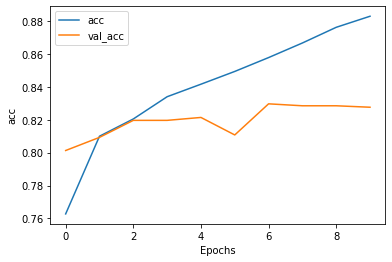

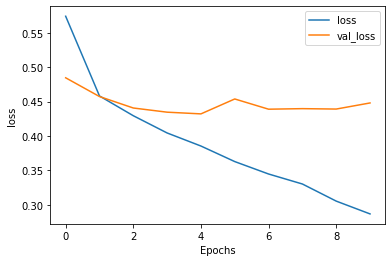

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length = max_length, weights=[embeddings_matrix], trainable=False),    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.005), metrics=['acc'])
# model.summary()
#adam(lr=.001>.0006)
num_epochs = 10
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

plot_graphs(history, "acc")
plot_graphs(history, "loss")